<a href="https://www.kaggle.com/code/kahnertk/retina-vessel-segmentation?scriptVersionId=140220477" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Retinal vessel segmentation

I am currently taking the fastai deep learning course: https://course.fast.ai/  

Current progress: end of lecture 2

In this notebook I am trying to implement what I have learned in the first two lectures of the course and build an image segmentation model using fastai/PyTorch and deploy the model to hugging face spaces using Gradio.

As training data I am using three published retina image data sets which have been combined and uploaded to Kaggle by Noob Data Scientist.
Link to the combined data set: https://www.kaggle.com/datasets/pradosh123/retinal-vessel-segmentation-combined  

Links to the original data sets:
* DRIVE: https://paperswithcode.com/dataset/drive
* STARE: https://paperswithcode.com/dataset/stare
* CHASE_DB1: https://paperswithcode.com/dataset/chase-db1

I will update this notebook as I progress in the course and try to improve the model performance.

## Install and import required packages

In [1]:
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai
    !pip install nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.4 MB/s eta 0:00:00


## Download images of birds and non-birds

In [24]:
import torch.multiprocessing
import matplotlib.pyplot as plt
from fastcore.all import *
from fastai.vision.all import *
from fastai.vision import *

Note: When training the model I randomly got end of file error and connection errors. I am not sure why this happens randomly but I the setting below seems to have fixed the issue.

In [3]:
torch.multiprocessing.set_sharing_strategy('file_system')

## Load and inspect images and masks

In [30]:
# set path to data set
data = Path('/kaggle/input/retinal-vessel-segmentation-combined/Retina Vessel Segmentation')
list(data.ls())

[Path('/kaggle/input/retinal-vessel-segmentation-combined/Retina Vessel Segmentation/Training'),
 Path('/kaggle/input/retinal-vessel-segmentation-combined/Retina Vessel Segmentation/Test'),
 Path('/kaggle/input/retinal-vessel-segmentation-combined/Retina Vessel Segmentation/Test Unlabeled')]

In [14]:
# get image paths
img_path = get_image_files(data/'Training'/'Images')
img_path

(#73) [Path('/kaggle/input/retinal-vessel-segmentation-combined/Retina Vessel Segmentation/Training/Images/Image_13R_CHASE.jpg'),Path('/kaggle/input/retinal-vessel-segmentation-combined/Retina Vessel Segmentation/Training/Images/21_DRIVE.tif'),Path('/kaggle/input/retinal-vessel-segmentation-combined/Retina Vessel Segmentation/Training/Images/07_dr_HRF.JPG'),Path('/kaggle/input/retinal-vessel-segmentation-combined/Retina Vessel Segmentation/Training/Images/Image_04R_CHASE.jpg'),Path('/kaggle/input/retinal-vessel-segmentation-combined/Retina Vessel Segmentation/Training/Images/04_dr_HRF.JPG'),Path('/kaggle/input/retinal-vessel-segmentation-combined/Retina Vessel Segmentation/Training/Images/05_g_HRF.jpg'),Path('/kaggle/input/retinal-vessel-segmentation-combined/Retina Vessel Segmentation/Training/Images/40_DRIVE.tif'),Path('/kaggle/input/retinal-vessel-segmentation-combined/Retina Vessel Segmentation/Training/Images/Image_05L_CHASE.jpg'),Path('/kaggle/input/retinal-vessel-segmentation-co

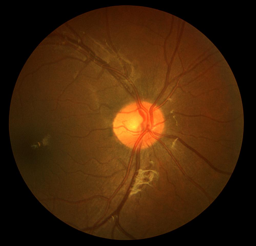

In [15]:
# inspect first image
img_f = img_path[0]
im = Image.open(img_f)
im.to_thumb(256,256)

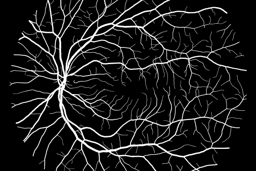

In [16]:
# get masks image paths and inspect first mask
mask_path = get_image_files(data/'Training'/'Masks')
mask_f = mask_path[0]
im = Image.open(mask_f)
im.to_thumb(256,256)

The order of the masks and image files seems to be different. To get the right masks to each image, I wrote the following function:

In [10]:
def get_y_fn(img_path):
    '''
    Function for the DataLoaders to grab the corresponding mask to each image.
    Takes the path of an image as input and returns the path of the corresponding mask.
    '''
    if "DRIVE" in img_path.stem:
        mask = data/'Training'/'Masks'/f'{img_path.stem}.gif'
    elif "CHASE" in img_path.stem:
        mask =  data/'Training'/'Masks'/f'{img_path.stem}.png'
    elif "HRF" in img_path.stem:
        mask =  data/'Training'/'Masks'/f'{img_path.stem}.tif'
    else:
        pass

    return mask

## Prepare DataLoaders

In [11]:
# define codes, item and batch transformations
codes = ["background", "vessel"]
batch_tfms = [IntToFloatTensor(div_mask=255),
              *aug_transforms(max_warp=0,
                              flip_vert=True, 
                              do_flip=True, 
                              max_rotate=45, 
                              max_lighting=0.4,
                              p_lighting=0.75)]
item_tfms = [RandomResizedCrop(400, min_scale=0.08)]

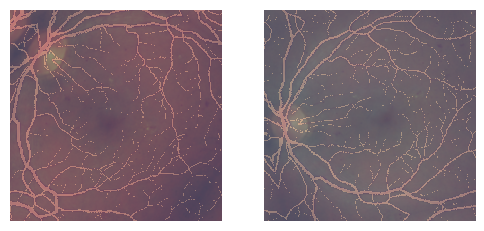

In [12]:
# initialize SegmentationDataLoaders object 
dls = SegmentationDataLoaders.from_label_func(
    data, bs=2, fnames = get_image_files(data/"Training"/"Images"),
    label_func = get_y_fn,
    codes = codes, 
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms
)

# display example batch to check if data is being loaded correctly 
dls.show_batch(max_n=20, vmin=0, vmax=1, unique=True)

## Build the segmentation model

For the segmentation task I will use the unet_learner from fastai using a pretrained resnet34 architecture.  
As performance metrics I will use the Dice and Jaccard coefficents as this seems to be the most appropriate for segmentation tasks as explained in this nice Medium article by Nghi Huynh:  
https://medium.com/mlearning-ai/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f

In [18]:
learn = unet_learner(dls, resnet34, n_out=2, metrics=[Dice, JaccardCoeff])

## Train the model

In [19]:
learn.fine_tune(epochs=120, base_lr=0.005)

Almost 0.8 Dice coefficient and 0.7 Jaccard coeffcient! Not too bad for a start!

## Inspect some predictions from the validation set

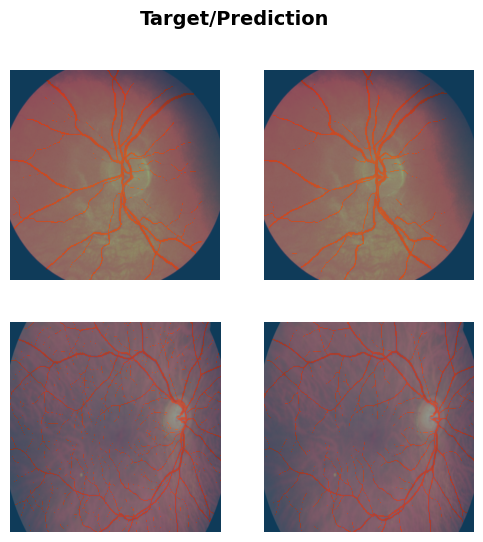

In [20]:
learn.show_results()

## Predict masks of test images and compare to manually labeled masks

In [31]:
def get_mask(img_path):
    '''
    Function to grab the corresponding mask to each image in the test data set.
    Takes the path of an image as input and returns the path of the corresponding mask.
    '''
    if "DRIVE" in img_path.stem:
        mask = data/'Test'/'Masks'/f'{img_path.stem}.gif'
    elif "CHASE" in img_path.stem:
        mask =  data/'Test'/'Masks'/f'{img_path.stem}.png'
    elif "HRF" in img_path.stem:
        mask =  data/'Test'/'Masks'/f'{img_path.stem}.tif'
    else:
        pass

    return mask

In [32]:
# get test images and masks
img_path = get_image_files(data/'Test'/'Images')
mask_path = get_image_files(data/'Test'/'Masks')

# predict masks
with learn.no_bar():    
    masks_pred = []
    for img in img_path:
        mask, *_ = learn.predict(img)
        masks_pred.append(mask)
    


In [1]:
??PIL.Image.open

Object `PIL.Image.open` not found.


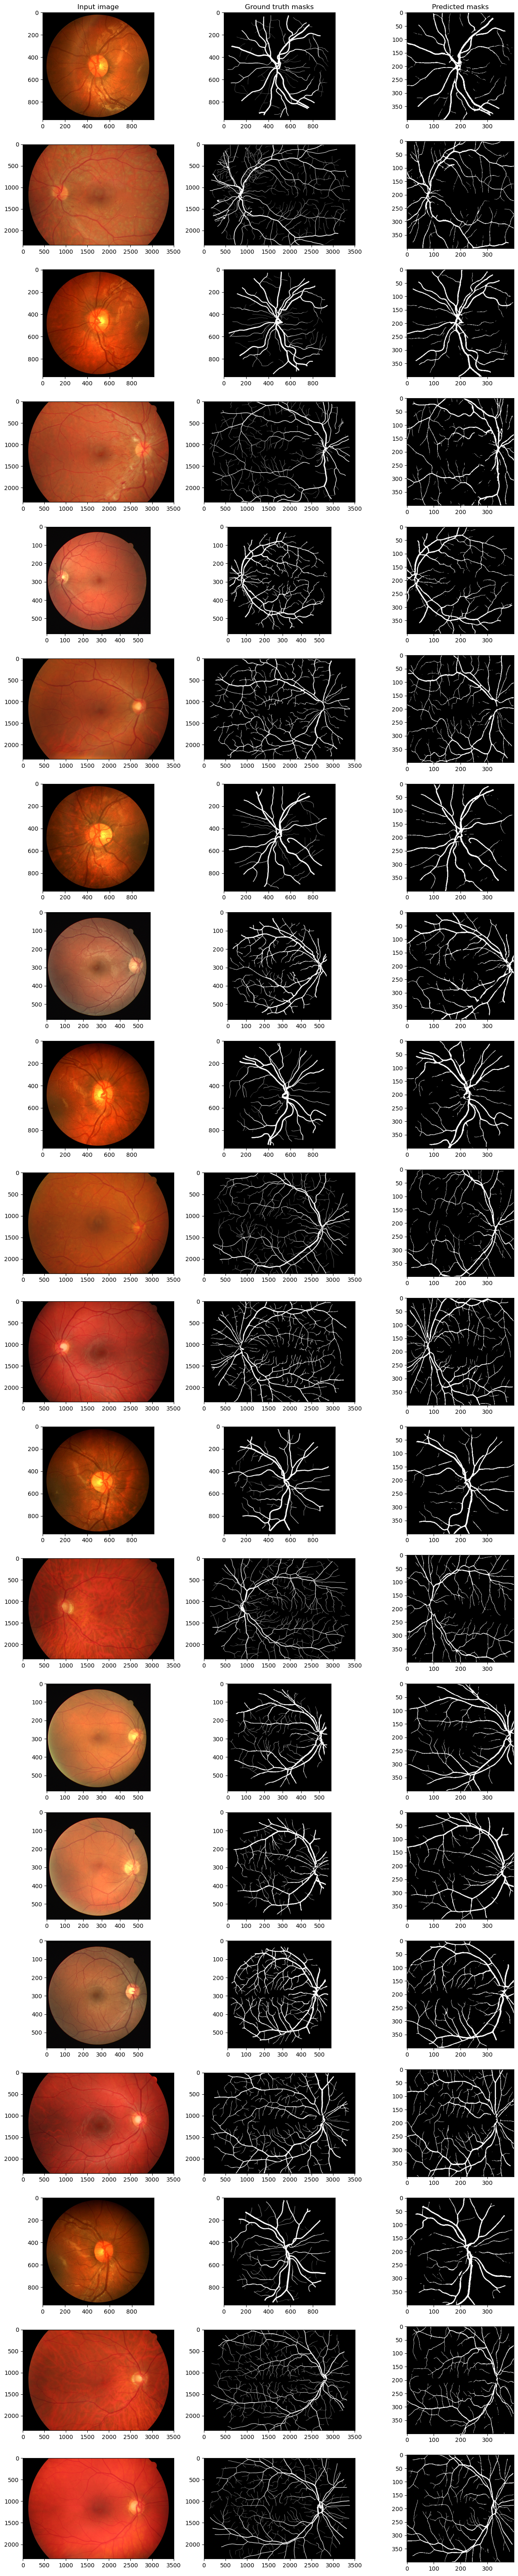

In [34]:
import PIL.Image
# plot images and masks
fig, axes = plt.subplots(20, 3, figsize=(16, 80))

for idx in range(20):
    axes[idx][0].imshow(PIL.Image.open(img_path[idx]))
    axes[idx][1].imshow(PIL.Image.open(get_mask(img_path[idx])), cmap="gray")
    axes[idx][2].imshow(masks_pred[idx], cmap="gray")
    
# add subtitles
axes[0][0].set_title('Input image')
axes[0][1].set_title('Ground truth masks')
axes[0][2].set_title('Predicted masks')

plt.show()

I would say, this looks already impressively good! :)

Take aways so far:
* higher resolution of the input images seems to produce better performance (but larger than arround 400 lead to GPU memory errors)
* color images worked better than grayscale images
* resnet34 worked better than resnet18. resnet50 and higher unfortunately always ran out of GPU memory
* data augmentation and the random cropping also improved model performance 

The different shape of some input images and the predicted masks is not ideal. I will have to work on that a bit more to see how I can solve this.

# Save the model

In [35]:
# export model
learn.export("/kaggle/working/vessel_seg.pkl")

# check if file exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('vessel_seg.pkl')]